In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
%matplotlib inline

from scipy.stats import skew
import sklearn
import xgboost
sns.set_style('whitegrid')

In [29]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [30]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [31]:
#将所有train和test放到一个表中便于处理
all_data = pd.concat((train.loc[:,'MSSubClass':'SaleCondition'],
                      test.loc[:,'MSSubClass':'SaleCondition']))

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


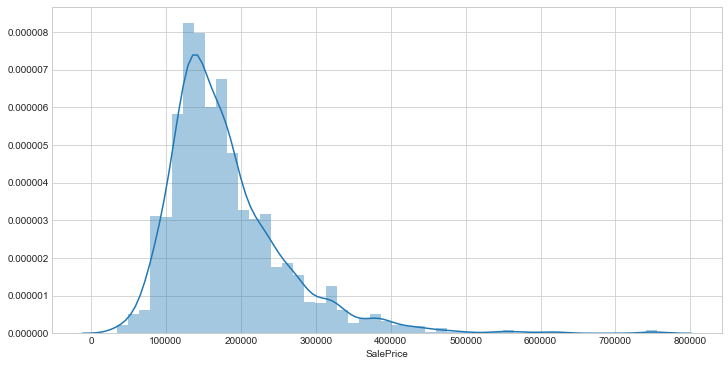

In [32]:
#看看标签值的分布情况
plt.subplots(figsize = (12,6))
sns.distplot(train.SalePrice)
#明显右偏
#使用对数转换

train.SalePrice = np.log(train.SalePrice)

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


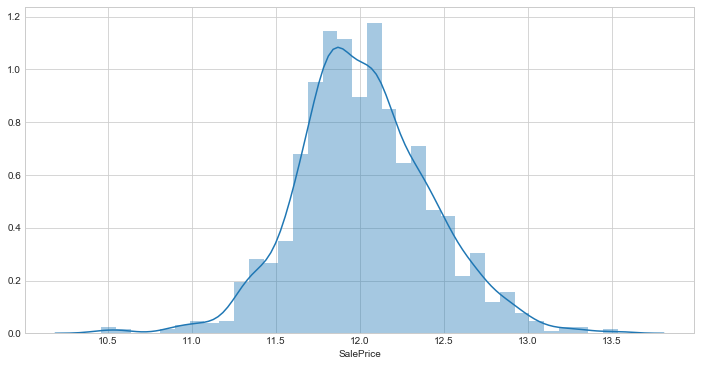

In [33]:
plt.subplots(figsize = (12,6))
sns.distplot(train.SalePrice)

In [34]:
#先看看缺失值
total = all_data.isnull().sum().sort_values(ascending = False)
percentage = round(all_data.isnull().sum()/len(all_data) * 100,2)
missing_data = pd.concat([total,percentage],axis = 1,keys = ['total','percentage'])
missing_data = missing_data.sort_values(by = 'total',ascending = False)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  after removing the cwd from sys.path.


In [35]:
missing_data.head(20)

,total,percentage
PoolQC,2909,99.66
MiscFeature,2814,96.40
Alley,2721,93.22
Fence,2348,80.44
FireplaceQu,1420,48.65
LotFrontage,486,16.65
GarageYrBlt,159,5.45
GarageQual,159,5.45
GarageFinish,159,5.45
GarageCond,159,5.45


In [36]:
#nan缺失率前面的全删了
all_data = all_data.drop(missing_data[:16].index,axis = 1)
all_data.head()

,MSSubClass,MSZoning,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,...,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,60,RL,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,...,61,0,0,0,0,0,2,2008,WD,Normal
1,20,RL,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,Veenker,...,0,0,0,0,0,0,5,2007,WD,Normal
2,60,RL,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,...,42,0,0,0,0,0,9,2008,WD,Normal
3,70,RL,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,...,35,272,0,0,0,0,2,2006,WD,Abnorml
4,60,RL,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,...,84,0,0,0,0,0,12,2008,WD,Normal


In [37]:
#查找出属于数值类型的特征
numeric_feature = all_data.dtypes[all_data.dtypes != object].index
#数值型的NAN值使用中位数来补
all_data[numeric_feature] = all_data[numeric_feature].fillna(all_data.median())


In [38]:
#在train数据集中计算这些特征的偏度
skewd_feat = train[numeric_feature].apply(lambda x :skew(x.dropna()))
#找出训练集中偏度大于0.75的特征
skewd_feat = skewd_feat[skewd_feat > 0.75].index


#将alldata中这些所有的特征全部对数转换,注意使用np.log1p，在特征上加1再取对，可以规避数值0
all_data[skewd_feat] = np.log1p(all_data[skewd_feat])

In [39]:
all_data[numeric_feature].mean()

MSSubClass          3.820503
LotArea             9.094915
OverallQual         6.089072
OverallCond         5.564577
YearBuilt        1971.312778
YearRemodAdd     1984.264474
MasVnrArea          2.079239
BsmtFinSF1          4.226981
BsmtFinSF2          0.680974
BsmtUnfSF           5.627325
TotalBsmtSF         6.733197
1stFlrSF            7.004186
2ndFlrSF            2.829584
LowQualFinSF        0.077100
GrLivArea           7.261502
BsmtFullBath        0.429599
BsmtHalfBath        0.042111
FullBath            1.568003
HalfBath            0.380267
BedroomAbvGr        2.860226
KitchenAbvGr        0.710829
TotRmsAbvGrd        6.451524
Fireplaces          0.597122
GarageCars          1.766701
GarageArea        472.877013
WoodDeckSF          2.449664
OpenPorchSF         2.333006
EnclosedPorch       0.757435
3SsnPorch           0.066197
ScreenPorch         0.451214
PoolArea            0.027361
MiscVal             0.234767
MoSold              6.213087
YrSold           2007.792737
dtype: float64

In [40]:
#然后将数值型变量进行归一化处理

all_data[numeric_feature] = (all_data[numeric_feature]-all_data[numeric_feature].min())/(all_data[numeric_feature].max()-all_data[numeric_feature].min())

In [41]:
all_data[numeric_feature].head()

,MSSubClass,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
0,0.483003,0.366271,0.666667,0.500,0.949275,0.883333,0.716038,0.759508,0.0,0.646838,...,0.368280,0.000000,0.624312,0.000000,0.0,0.0,0.0,0.0,0.090909,0.50
1,0.000000,0.391245,0.555556,0.875,0.753623,0.433333,0.000000,0.797188,0.0,0.728731,...,0.309140,0.784977,0.000000,0.000000,0.0,0.0,0.0,0.0,0.363636,0.25
2,0.483003,0.422289,0.666667,0.500,0.934783,0.866667,0.690361,0.716357,0.0,0.783246,...,0.408602,0.000000,0.568957,0.000000,0.0,0.0,0.0,0.0,0.727273,0.50
3,0.551764,0.390223,0.666667,0.500,0.311594,0.333333,0.000000,0.622780,0.0,0.811361,...,0.431452,0.000000,0.542079,0.810539,0.0,0.0,0.0,0.0,0.090909,0.00
4,0.483003,0.468694,0.777778,0.500,0.927536,0.833333,0.794318,0.750841,0.0,0.798858,...,0.561828,0.724696,0.672040,0.000000,0.0,0.0,0.0,0.0,1.000000,0.50


In [42]:
#独热编码
all_data = pd.get_dummies(all_data)

In [43]:
all_data.head()

,MSSubClass,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,0.483003,0.366271,0.666667,0.500,0.949275,0.883333,0.716038,0.759508,0.0,0.646838,...,0,0,0,1,0,0,0,0,1,0
1,0.000000,0.391245,0.555556,0.875,0.753623,0.433333,0.000000,0.797188,0.0,0.728731,...,0,0,0,1,0,0,0,0,1,0
2,0.483003,0.422289,0.666667,0.500,0.934783,0.866667,0.690361,0.716357,0.0,0.783246,...,0,0,0,1,0,0,0,0,1,0
3,0.551764,0.390223,0.666667,0.500,0.311594,0.333333,0.000000,0.622780,0.0,0.811361,...,0,0,0,1,1,0,0,0,0,0
4,0.483003,0.468694,0.777778,0.500,0.927536,0.833333,0.794318,0.750841,0.0,0.798858,...,0,0,0,1,0,0,0,0,1,0


In [44]:
all_data[numeric_feature].mean()

MSSubClass       0.351480
LotArea          0.376622
OverallQual      0.565452
OverallCond      0.570572
YearBuilt        0.719658
YearRemodAdd     0.571075
MasVnrArea       0.281801
BsmtFinSF1       0.489317
BsmtFinSF2       0.092889
BsmtUnfSF        0.725486
TotalBsmtSF      0.772346
1stFlrSF         0.437186
2ndFlrSF         0.370686
LowQualFinSF     0.011061
GrLivArea        0.512518
BsmtFullBath     0.143200
BsmtHalfBath     0.038331
FullBath         0.392001
HalfBath         0.190134
BedroomAbvGr     0.357528
KitchenAbvGr     0.512754
TotRmsAbvGrd     0.342425
Fireplaces       0.149281
GarageCars       0.353340
GarageArea       0.317794
WoodDeckSF       0.337330
OpenPorchSF      0.352914
EnclosedPorch    0.109445
3SsnPorch        0.010621
ScreenPorch      0.070970
PoolArea         0.004092
MiscVal          0.024101
MoSold           0.473917
YrSold           0.448184
dtype: float64

In [45]:
#使用平均值填补缺失值
all_data = all_data.fillna(all_data.mean())
all_data.isnull().sum().max()

0

In [52]:
#将alldata分为训练集和测试集，为建模做准备
X_train = all_data[:train.shape[0]]
y_train = train['SalePrice']
X_test = all_data[train.shape[0]:]

X_train.to_csv('X_train.csv',index = False)
y_train.to_csv('y_train.csv',index = False)
X_test.to_csv('X_test.csv',index = False)

In [60]:
X_train = pd.read_csv('X_train.csv')
y_train = pd.read_csv('y_train.csv',header = None)
X_test = pd.read_csv('X_test.csv')

In [63]:
X_test.shape

(1459, 225)

In [64]:
#导入sklearn算法
#使用正则化的线性回归模型来预测,同时使用LASSO正则式和RIDGE正则式
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV,Lasso
from sklearn.model_selection import cross_val_score

def rmse_cv(model):
    rmse= np.sqrt(-cross_val_score(model, X_train, y_train, scoring="neg_mean_squared_error", cv = 5))
    return(rmse)

In [16]:
ridge1 = Ridge()

In [70]:

cross_val_score(Ridge(alpha = 0.05), X_train, y_train, scoring="neg_mean_squared_error", cv = 5)

array([-0.0127461 , -0.01986086, -0.02058992, -0.01340156, -0.0251202 ])

In [72]:
#先使用ridge正则式，l2范数，选取最佳alpha
alphas = [0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75]
cv_ridge = [rmse_cv(Ridge(alpha = alpha)).mean() 
            for alpha in alphas]

Text(0,0.5,'rmse')

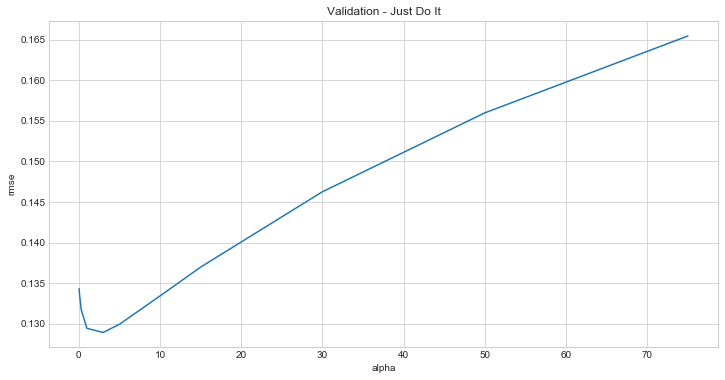

In [73]:
cv_ridge = pd.Series(cv_ridge, index = alphas)
plt.subplots(figsize=(12,6))
cv_ridge.plot(title = "Validation - Just Do It")

plt.xlabel("alpha")
plt.ylabel("rmse")

In [75]:
#可以看出alpha为3时，有最低根方差0.129
cv_ridge.min()

0.1289214142504518

In [65]:
#现在查看LASSO,l1范数正则化，一般来说l1范数的最佳lambda是l2范数的倒数
model_lasso = LassoCV(cv = 5).fit(X_train,y_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:1100: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [66]:
cv_lasso = rmse_cv(model_lasso)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:1100: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:1100: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:1100: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:1100: DataConversionWarning: A column-vector y was passed when a 1d arr

In [67]:
#使用lasso l1范数的最低根方差为0.123，那我们决定使用l1范数
cv_lasso.mean()

0.12295032451538494

In [68]:
#l1范数回归还是可以帮我们将一些不重要的特征的weight调整为0
coeff = pd.Series(model_lasso.coef_,index = X_train.columns)

In [69]:
#当然这些调整也不一定准确，我们可以把weight打印出来看看
print(f'The Lasso Regularization Keeps {len(coeff[coeff != 0 ])} Features and\
eliminates {len(coeff[coeff == 0 ])} Features')

The Lasso Regularization Keeps 96 Features andeliminates 129 Features


In [70]:
neg_coeff = coeff.sort_values()[:10]
pos_coeff = coeff.sort_values()[-10:]

In [71]:
df = pd.concat((pos_coeff,neg_coeff)).sort_values(ascending = True)

Text(0.5,1,'Coefficients in the Lasso Model')

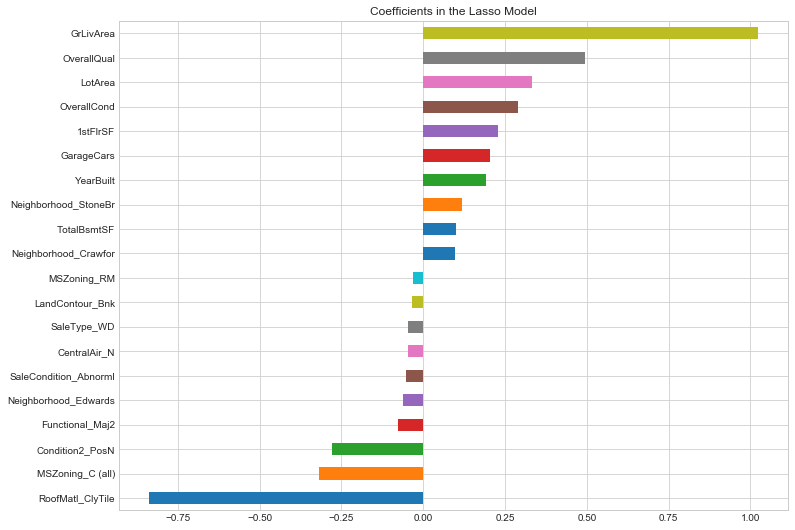

In [72]:
#可以看出排名前列的特征与之前分析的差不多
plt.subplots(figsize = (12,9))
df.plot(kind='barh')
plt.title("Coefficients in the Lasso Model")

In [73]:
y_train_list = [x for x in y_train.loc[:,0]]

In [74]:
#现在我们来看看残差的分布
residual = pd.DataFrame({
    'preds':model_lasso.predict(X_train),
    'residual':y_train_list - model_lasso.predict(X_train)
})

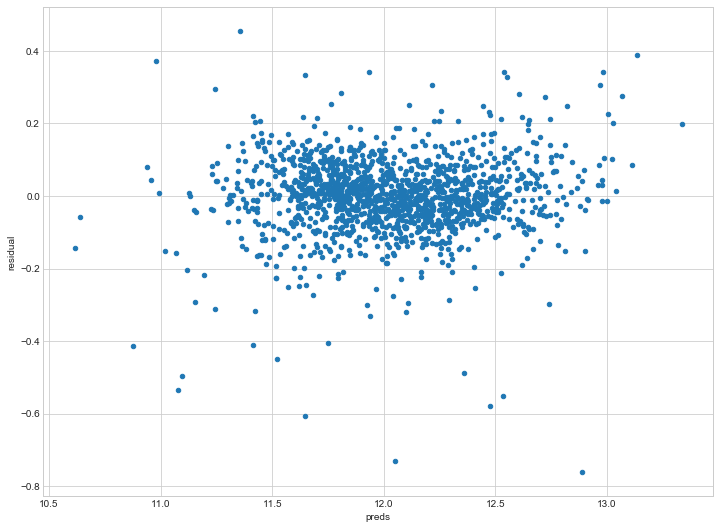

In [75]:
#残差分布在还不错，比较集中
plt.rcParams['figure.figsize'] = (12,9)
residual.plot(x = 'preds',y = 'residual',kind = 'scatter')


In [76]:
#现在我们使用模型对测试集进行预测
model_lasso.predict(X_test)
preds = pd.DataFrame(np.exp(model_lasso.predict(X_test)))

In [77]:
test_num = pd.read_csv('test.csv')

In [78]:
submission = pd.concat((test_num['Id'],preds),names = ['Id','SalePrice'],axis = 1)

In [5]:
# submission = pd.read_csv('submission_LassoLR.csv')

In [81]:
#注意将id列变量类型转换为int32
submission.columns = ['Id','SalePrice']
# submission['Id'] = submission['Id'].astype('int32')

submission['Id'] = submission['Id'].astype('int32')
submission.dtypes

Id             int32
SalePrice    float64
dtype: object

In [83]:
submission.to_csv('submission_LassoLR.csv',index = False)